In [1]:
# Cell 1: Setup
import data_loader
import importlib
importlib.reload(data_loader)

#print(f"Box size1: {BOX_SIZE}")

# Setup
from data_loader import *
import matplotlib.pyplot as plt
import numpy as np

print("BOX_SIZE2:", BOX_SIZE)


Loading bubble data...
✓ Loaded 634277 observations
✓ Timesteps added: 0 to 3426
✓ Identified 300 disappearing bubbles
Applying periodic boundary corrections...
✓ Periodic boundary correction applied
✓ Derived quantities computed

DATA LOADING COMPLETE
Total observations:       634,277
Unique bubbles:           400
Timesteps:                0 to 3426
Disappearing bubbles:     300
Box size:                 22.36068
Initial avg area (A_0):   1.000000

Available variables:
  - df: Original dataframe
  - df_corrected: Corrected dataframe with actual_area column
  - disappearing_ids: Set of disappearing bubble IDs
  - bubbles_per_timestep: Number of bubbles at each timestep
  - avg_area_per_timestep: Average bubble area at each timestep
  - approx_avg_area: Approximate area from liquid fraction
  - A_0: Initial average bubble area
  - max_timestep: Maximum timestep
  - final_step: Final timestep
  - box_area: Total box area
  - BOX_SIZE, PERIODIC_THRESHOLD, LIQUID_FRACTION: Constants

Loadi

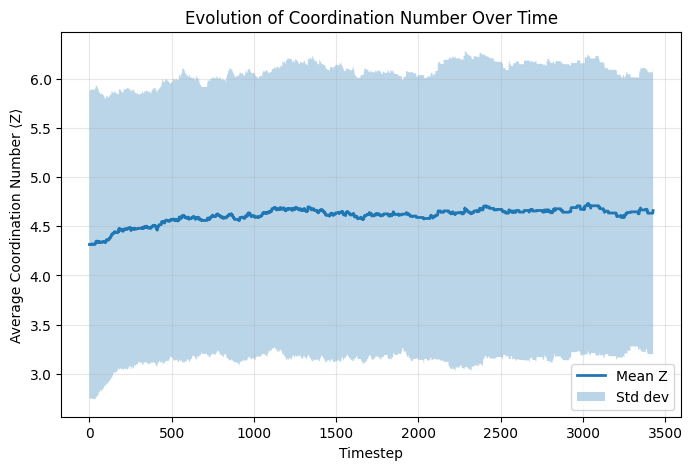

In [2]:
# Average coordination number over time
Z_mean = df_corrected.groupby("timestep")["Z"].mean()
Z_std = df_corrected.groupby("timestep")["Z"].std()

plt.figure(figsize=(8,5))
plt.plot(Z_mean.index, Z_mean, label='Mean Z', lw=2)
plt.fill_between(Z_mean.index, Z_mean-Z_std, Z_mean+Z_std, alpha=0.3, label='Std dev')
#plt.axhline(6, color='r', ls='--', label='Ideal foam (Z=6)', markersize=0.05)
plt.xlabel("Timestep")
plt.ylabel("Average Coordination Number ⟨Z⟩")
plt.legend()
plt.title("Evolution of Coordination Number Over Time")
plt.grid(alpha=0.3)
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/07_Figures/evolution_of_coordination_number_over_time_2.png", dpi=300)
plt.show()

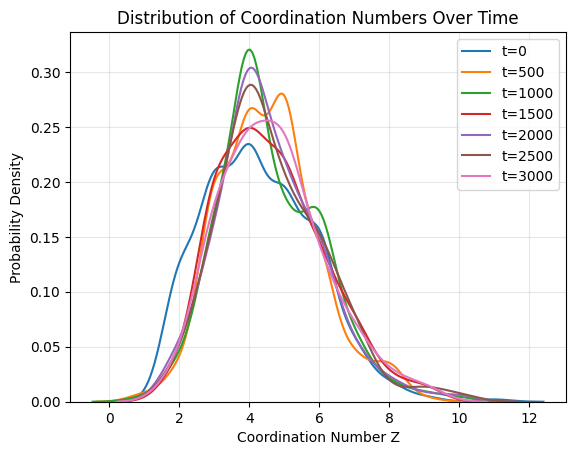

In [3]:
import seaborn as sns

for t in sorted(df_corrected["timestep"].unique())[::500]:  # plot every 100th frame for clarity
    sns.kdeplot(df_corrected[df_corrected["timestep"]==t]["Z"], label=f"t={t}")

plt.xlabel("Coordination Number Z")
plt.ylabel("Probability Density")
plt.title("Distribution of Coordination Numbers Over Time")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/07_Figures/distribution_of_coordination_numbers_over_time_2.png", dpi=300)
plt.show()

# sum should equal to 1
# plot as discrete points

Check normalisation: 0.9999999999999999


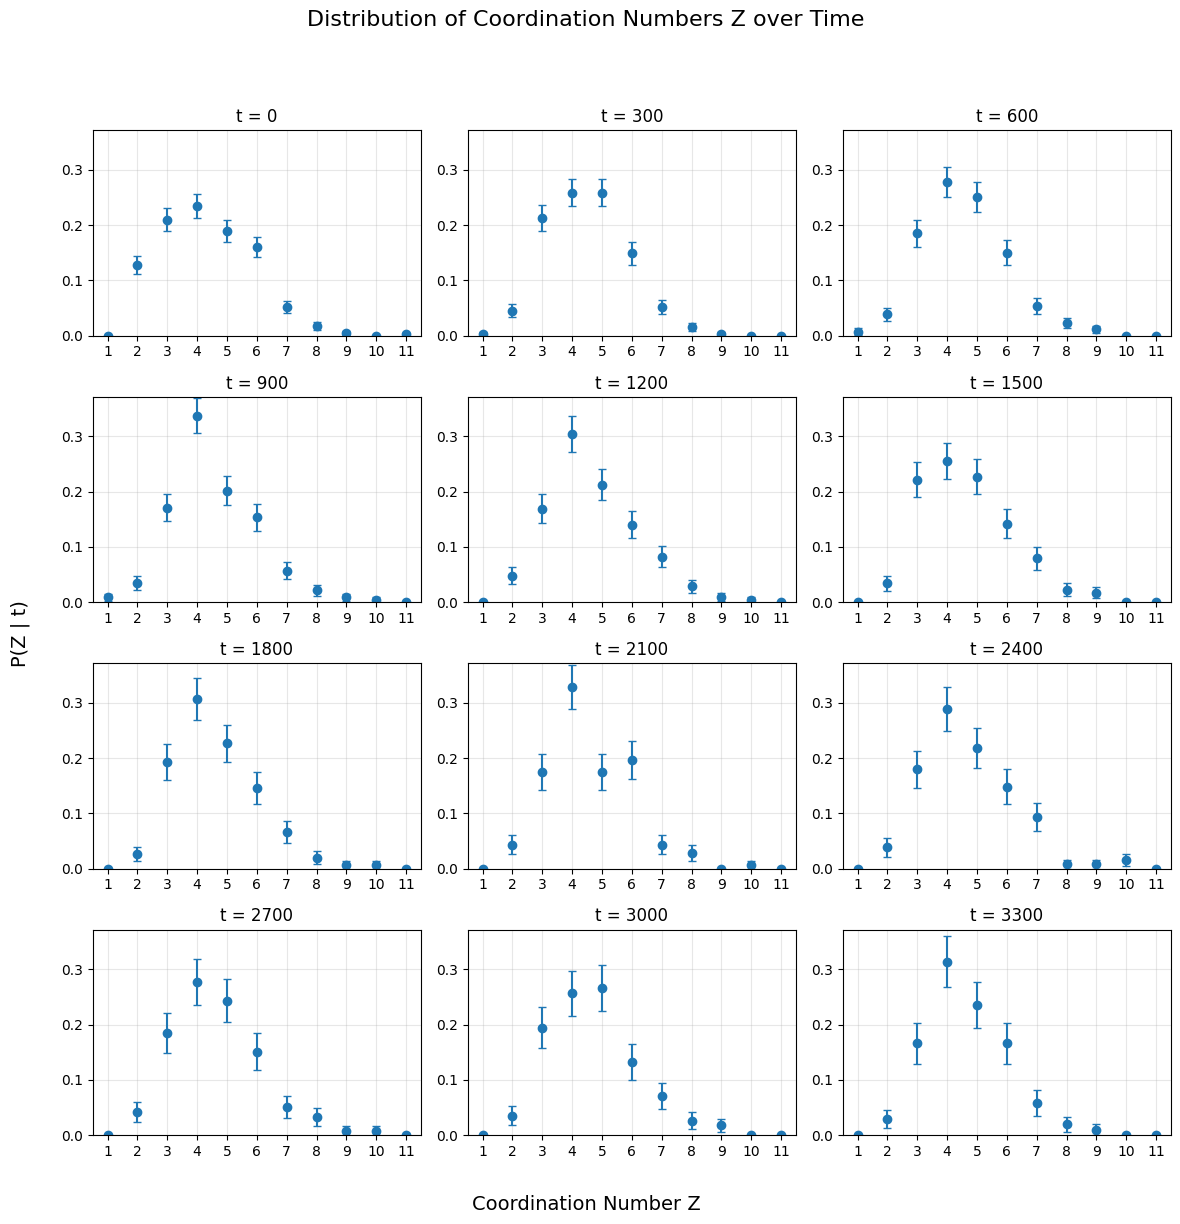

In [4]:
timesteps = sorted(df_corrected["timestep"].unique())[::300]

# all possible Z values (discrete support)
z_values = np.sort(df_corrected["Z"].unique())

# containers for probabilities & errors so we can set common axes
probs_by_t = {}
errs_by_t = {}
y_max = 0.0

for t in timesteps:
    Z_t = df_corrected.loc[df_corrected["timestep"] == t, "Z"].to_numpy()
    N = len(Z_t)

    # counts for each Z in z_values
    counts = np.array([(Z_t == z).sum() for z in z_values])

    # normalised probabilities: sum should be 1
    probs = counts / N

    # binomial standard error for each probability p
    # (gives error bars; where p=0, error is 0)
    errs = np.sqrt(probs * (1 - probs) / N)

    probs_by_t[t] = probs
    errs_by_t[t] = errs

    if probs.max() > y_max:
        y_max = probs.max()

# optional sanity check for one timestep
print("Check normalisation:", probs_by_t[timesteps[0]].sum())

# --- plotting: separate subplots with shared axes ---

n_plots = len(timesteps)
ncols = 3
nrows = int(np.ceil(n_plots / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(4 * ncols, 3 * nrows)
)

axes = np.array(axes).ravel()

for ax, t in zip(axes, timesteps):
    probs = probs_by_t[t]
    errs = errs_by_t[t]

    ax.errorbar(
        z_values,
        probs,
        yerr=errs,
        fmt='o',
        capsize=3,
        linestyle='none'
    )
    ax.set_title(f"t = {t}", fontsize=12)
    ax.grid(alpha=0.3)
    ax.set_xticks(z_values)

    ax.set_xlim(z_values.min() - 0.5, z_values.max() + 0.5)
    ax.set_ylim(0, y_max * 1.1)

# hide empty axes
for ax in axes[n_plots:]:
    ax.set_visible(False)

# --- global labels ---
fig.suptitle("Distribution of Coordination Numbers Z over Time", fontsize=16, y=1.02)
fig.text(0.5, 0.02, "Coordination Number Z", ha="center", fontsize=14)
fig.text(0.02, 0.5, "P(Z | t)", va="center", rotation="vertical", fontsize=14)

fig.tight_layout(rect=[0.05, 0.05, 1, 0.98])
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/07_Figures/distribution_of_coordination_numbers_subplots_2.png", dpi=300)
plt.show()

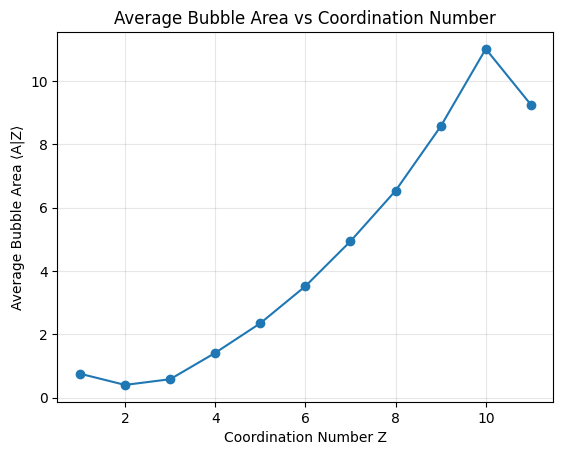

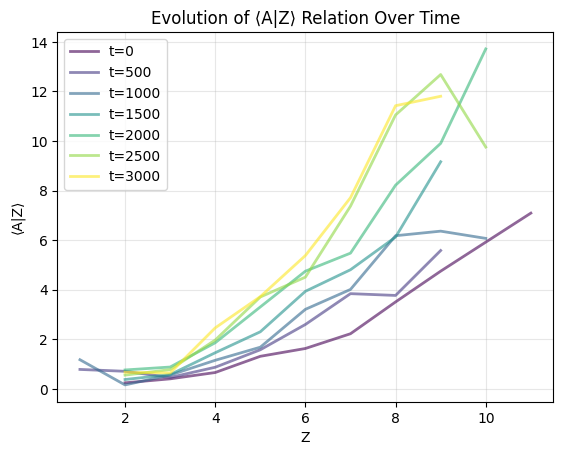

In [5]:

# Relationship between Z and bubble area (area is radius, so convert to actual area)

# Calculate average area for each coordination number Z
# Group by Z and compute mean area 
z_area_relation = df_corrected.groupby("Z")["actual_area"].mean()

z_area_relation.plot(marker='o')
plt.xlabel("Coordination Number Z")
plt.ylabel("Average Bubble Area ⟨A|Z⟩")
plt.title("Average Bubble Area vs Coordination Number")
plt.grid(True, alpha=0.3)
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/07_Figures/average_bubble_area_vs_coordination_number_2.png", dpi=300)
plt.show()

time_groups = df_corrected.groupby("timestep")

# Use a colormap for distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(list(time_groups)[::500])))

for idx, (t, g) in enumerate(list(time_groups)[::500]):
    z_area = g.groupby("Z")["area"].apply(lambda x: (np.pi * x**2).mean())
    plt.plot(z_area.index, z_area.values, alpha=0.6, label=f"t={t}", color=colors[idx], linewidth=2)

plt.xlabel("Z")
plt.ylabel("⟨A|Z⟩")
plt.title("Evolution of ⟨A|Z⟩ Relation Over Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/07_Figures/evolution_of_A_vs_Z_at_different_times_2.png", dpi=300)
plt.show()


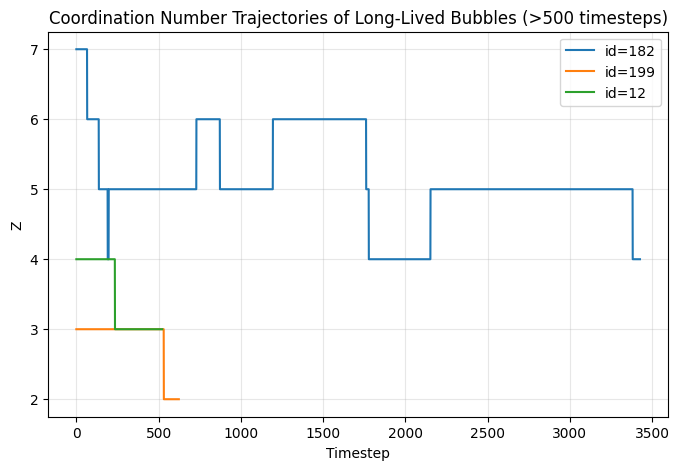

In [6]:
# Find bubbles that survive more than 500 timesteps
bubble_lifetimes = df_corrected.groupby("id")["timestep"].count()
long_lived_bubbles = bubble_lifetimes[bubble_lifetimes > 500].index

# Sample from long-lived bubbles only
sample_bubbles = np.random.choice(long_lived_bubbles, size=min(3, len(long_lived_bubbles)), replace=False)

plt.figure(figsize=(8,5))
for bid in sample_bubbles:
    g = df_corrected[df_corrected["id"]==bid]
    plt.plot(g["timestep"], g["Z"], label=f"id={bid}")

plt.xlabel("Timestep")
plt.ylabel("Z")
plt.title("Coordination Number Trajectories of Long-Lived Bubbles (>500 timesteps)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

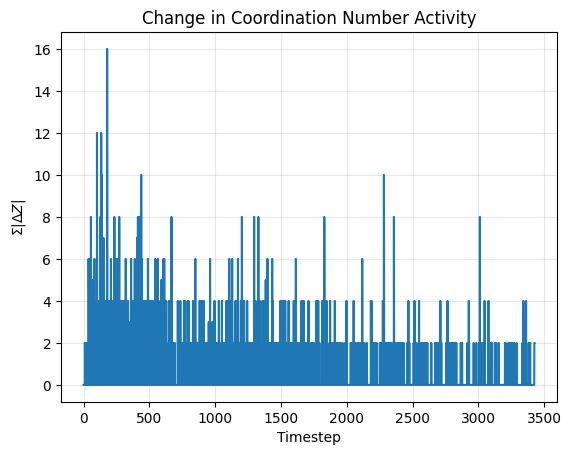

In [7]:
# Topological rearrangement activity, how busy the change in Z is over time

df_sorted = df.sort_values(["id", "timestep"]) # Ensure data is sorted by bubble id and timestep
df_sorted["dZ"] = df_sorted.groupby("id")["Z"].diff().abs() # Absolute change in Z per bubble

activity = df_sorted.groupby("timestep")["dZ"].sum() # Sum of absolute changes in Z at each timestep
plt.plot(activity.index, activity.values)
plt.xlabel("Timestep")
plt.ylabel(r"$\Sigma|\Delta Z|$") # Total topological rearrangement activity
plt.title("Change in Coordination Number Activity")
plt.grid(alpha=0.3)
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/07_Figures/change_in_coordination_number_activity_2.png", dpi=300)
plt.show()

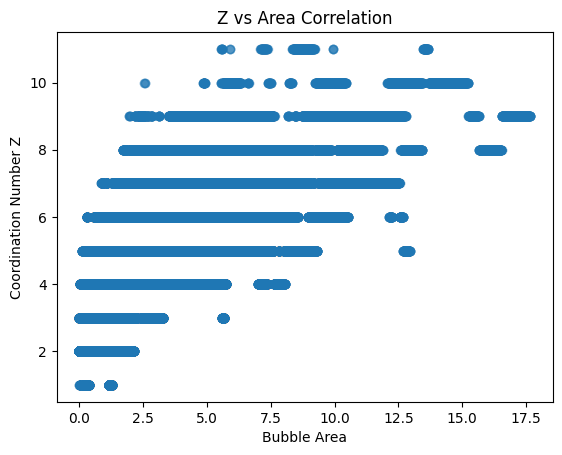

Correlation between area and Z: 0.686


/var/folders/l1/x0797x3512d9sktcpm47npbh0000gn/T/ipykernel_14474/376721868.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_corrected.groupby("area_bin")["Z"]


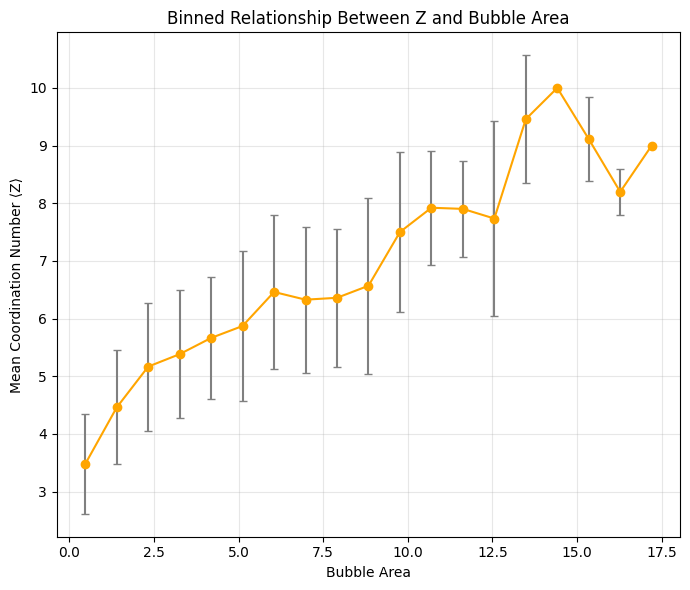

In [8]:

plt.scatter(df_corrected["actual_area"], df_corrected["Z"], alpha=0.3)
plt.xlabel("Bubble Area")
plt.ylabel("Coordination Number Z")
plt.title("Z vs Area Correlation")
plt.show()

corr = df_corrected["actual_area"].corr(df_corrected["Z"])
print(f"Correlation between area and Z: {corr:.3f}")

# Binned analysis of Z vs area
bins = np.linspace(df_corrected["actual_area"].min(),
                   df_corrected["actual_area"].max(), 20)
df_corrected["area_bin"] = pd.cut(df_corrected["actual_area"], bins)

grouped = df_corrected.groupby("area_bin")["Z"]
bin_centers = [interval.mid for interval in grouped.mean().index]
mean_Z = grouped.mean().values
std_Z = grouped.std().values

plt.figure(figsize=(7,6))
plt.errorbar(bin_centers, mean_Z, yerr=std_Z, fmt='o-', color='orange',
             ecolor='gray', capsize=3)
plt.xlabel("Bubble Area")
plt.ylabel("Mean Coordination Number ⟨Z⟩")
plt.title("Binned Relationship Between Z and Bubble Area")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/07_Figures/Z_vs_area_with_errorbars_2.png", dpi=300)
plt.show()


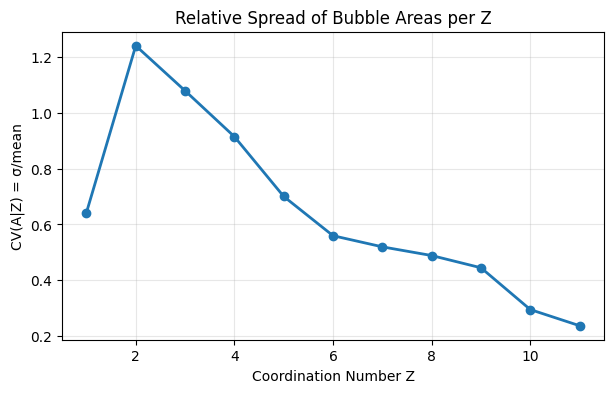

In [9]:
# per-Z mean and std (aggregate)
stats_Z = df_corrected.groupby("Z")["actual_area"].agg(["mean","std","count"]) 
# Coefficient of variation
stats_Z["cv"] = stats_Z["std"] / stats_Z["mean"]
Zs = stats_Z.index.values



# Plot coefficient of variation vs Z 
plt.figure(figsize=(7,4))
plt.plot(Zs, stats_Z["cv"].values, marker='o', lw=2)
plt.xlabel("Coordination Number Z"); plt.ylabel("CV(A|Z) = σ/mean")
plt.title("Relative Spread of Bubble Areas per Z")
plt.grid(alpha=0.3)
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/07_Figures/cv_vs_Z_2.png", dpi=300)
plt.show()

# Variance and Second Moment

The variance of the coordination number distribution is equivalent to its second moment about the mean:

$$\text{Var}(Z) = \sigma^2 = \langle (Z - \langle Z \rangle)^2 \rangle = \mu_2$$

This quantity characterizes the width or spread of the distribution and is a key measure of topological disorder in the foam structure.

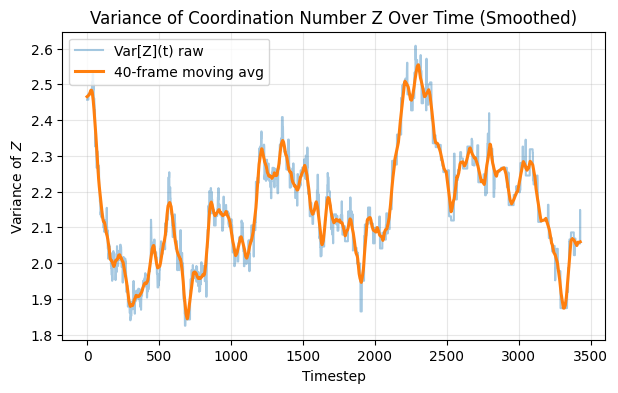

In [10]:
# Compute variance and std of coordination number Z over time
Z_var = df_corrected.groupby("timestep")["Z"].var()
Z_std = df_corrected.groupby("timestep")["Z"].std()

# Apply moving average 
window = 40
Z_var_smooth = Z_var.rolling(window=window, min_periods=1, center=True).mean()
Z_std_smooth = Z_std.rolling(window=window, min_periods=1, center=True).mean()

# Plot variance with smoothing
plt.figure(figsize=(7,4))
plt.plot(Z_var.index, Z_var, lw=1.5, alpha=0.4, label=r'Var[Z](t) raw')
plt.plot(Z_var.index, Z_var_smooth, lw=2.2, label=fr'{window}-frame moving avg')
plt.xlabel("Timestep")
plt.ylabel(r"Variance of $Z$")
plt.title("Variance of Coordination Number Z Over Time (Smoothed)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/07_Figures/smoothed_variance_of_coordination_number_over_time_2.png", dpi=300)
plt.show()

# account for dryness and contact angle
# plateau borders. 


## Verifying Second Moment Calculation

The following code verifies that the second moment is correctly computed as:

$$\mu_2(t) = \sum_Z (Z - \langle Z \rangle_t)^2 \, p_t(Z)$$

where $p_t(Z)$ is the probability distribution of coordination numbers at time $t$.


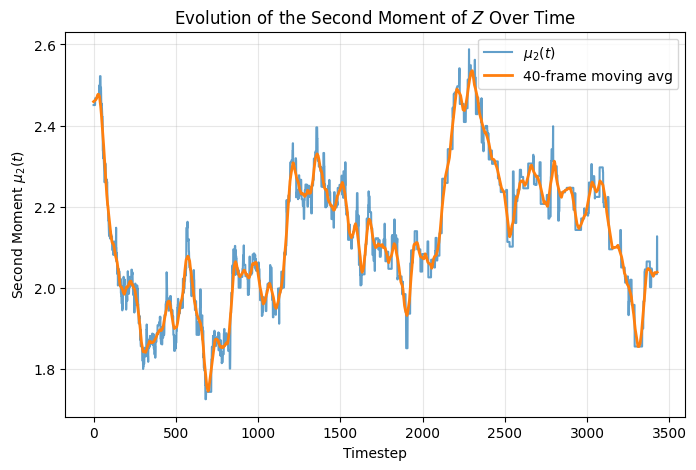

In [11]:
timesteps = sorted(df_corrected["timestep"].unique())
mu2, mu2_norm = [], []

for t in timesteps:
    z_vals = df_corrected.loc[df_corrected["timestep"] == t, "Z"].dropna()
    counts, bins = np.histogram(z_vals, bins=range(2, 18), density=True)
    centers = 0.5 * (bins[:-1] + bins[1:])
    
    mean_z = np.sum(centers * counts)
    mu2_t = np.sum((centers - mean_z)**2 * counts)
    mu2.append(mu2_t)
    mu2_norm.append(mu2_t / mean_z**2)

plt.figure(figsize=(8,5))
plt.plot(timesteps, mu2, label=r'$\mu_2(t)$', alpha=0.7)
plt.plot(timesteps, pd.Series(mu2).rolling(40, center=True, min_periods=1).mean(), 
         lw=2, label='40-frame moving avg')
plt.xlabel("Timestep")
plt.ylabel(r"Second Moment $\mu_2(t)$")
plt.title("Evolution of the Second Moment of $Z$ Over Time")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/07_Figures/evolution_of_second_moment_of_Z_over_time_2.png", dpi=300)
plt.show()




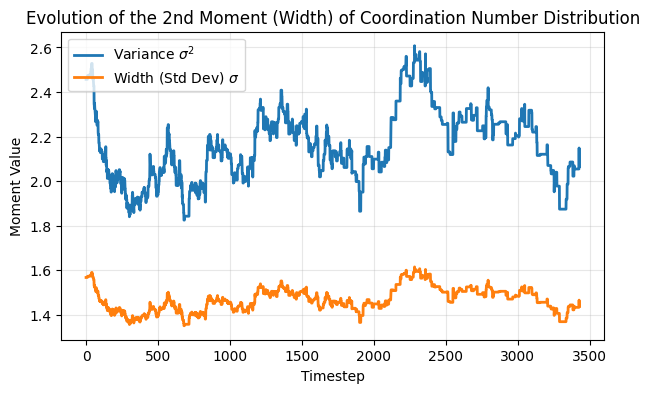

In [12]:
Z_mean = df_corrected.groupby("timestep")["Z"].mean()
Z_var  = df_corrected.groupby("timestep")["Z"].var()
Z_std  = np.sqrt(Z_var)

plt.figure(figsize=(7,4))
plt.plot(Z_var.index, Z_var, label="Variance $\sigma^2$", lw=2)
plt.plot(Z_std.index, Z_std, label="Width (Std Dev) $\sigma$", lw=2)
plt.xlabel("Timestep")
plt.ylabel("Moment Value")
plt.title("Evolution of the 2nd Moment (Width) of Coordination Number Distribution")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/07_Figures/evolution_of_2nd_moment_of_coordination_number_distribution_2.png", dpi=300)
plt.show()